# Predicting Risk of Heart Disease Using Clinical Indicators

# Introduction
Heart disease is a leading cause of death worldwide, and early prediction can significantly improve patient outcomes. Machine learning techniques can be used to analyze clinical and demographic data to predict the presence of heart disease. This project will utilize a modified version of the UCI Heart Disease dataset to develop a predictive model for heart disease. 
### Research Question:
Can we accurately predict the presence of heart disease (`num`) from processed Cleveland dataset (using `age`, `trestbps`, `chol`, and `thalach` as predictor variable)?
### Dataset:
The dataset used for this analysis is a modified version of the UCI Heart Disease dataset (processed Cleveland data). It contains 14 columns but I will only use 5 columns mentioned below.

1. `age`: age (years)

2. `trestbps`: resting blood pressure (in $mm$ $Hg$ on admission to the hospital)

3. `chol`: serum cholesterol in $mg/dl$

4. `thalach`: maximum heart rate achieved

5. `num`: diagnosis of heart disease (the predicted attribute)

            -- Value 0: No heart disease diagnosed
    
            -- Value 1 - 4: Heart disease diagnosed (1 being least severe and 4 being most severe heart disease)

# Preliminary exploratory data analysis:

In [1]:
#run this cell ; it loads the libraries for us to use.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Reading Data into Jupyter Lab

In [2]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/static/public/45/heart+disease.zip", temp)
con_cleveland <- unzip(temp, "processed.cleveland.data")
cleveland_data <- read.table(con_cleveland, sep = ",", col.names = c("age", "sex", "cp", "trestbps", "chol", 
                                         "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

head(cleveland_data)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
6,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


## Cleaning Data
In this project I am only focusing on 4 variables `age`, `trestbps`, `chol`, and `thalach` to predict `num` (Diagnosis of Heart Disease). Therefore I will select the above mentioned 4 columns using `select()` and converting our `num` column from integer to categorical using `mutate()`.

In [3]:
cleveland_data <- cleveland_data |> 
                   select(age, trestbps, chol, thalach, num) |> 
                    mutate(num = as_factor(num))
head(cleveland_data)

,age,trestbps,chol,thalach,num
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,145,233,150,0
2,67,160,286,108,2
3,67,120,229,129,1
4,37,130,250,187,0
5,41,130,204,172,0
6,56,120,236,178,0


## Splitting Data into Training set and Testing set

In [4]:
set.seed(2000)

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

cleveland_training

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0
37,130,250,187,0
41,130,204,172,0
⋮,⋮,⋮,⋮,⋮
55,128,205,130,3
59,164,176,90,3
57,130,131,115,3


## Summary Table
This table shows the number of observation per different value of `num`with their respective mean values for `age`, `chol`, `trestbps`, and `thalach`

In [8]:
summary_cleveland_training <- cleveland_training |> group_by(num) |> summarize(count = n(),
                                                                               mean_age = mean(age, na.rm = TRUE),
                                                                               mean_trestbps = mean(trestbps, na.rm = TRUE),
                                                                               mean_chol = mean(chol, na.rm = TRUE),
                                                                               mean_thalach = mean(thalach, na.rm = TRUE))

summary_cleveland_training

num,count,mean_age,mean_trestbps,mean_chol,mean_thalach
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,122,52.96721,128.8115,244.4754,158.4672
1,40,54.87500,133.6500,250.5250,147.7000
2,26,57.69231,132.6923,261.3846,138.2308
3,26,55.73077,136.3462,248.8846,134.1154
4,12,61.50000,140.3333,255.2500,137.1667


## Visualization of Data
The plot below shows distribution different predictors `age`, `trestbps`, `chol`, and `thalach` by Heart disease status to better understand the relation ship of the predictors with `num`.

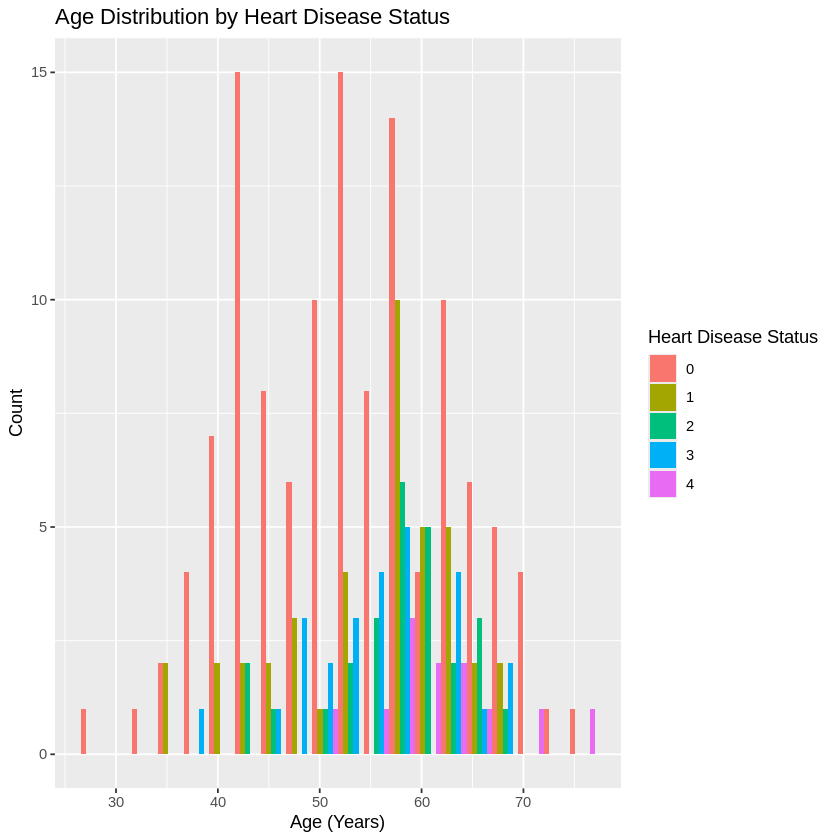

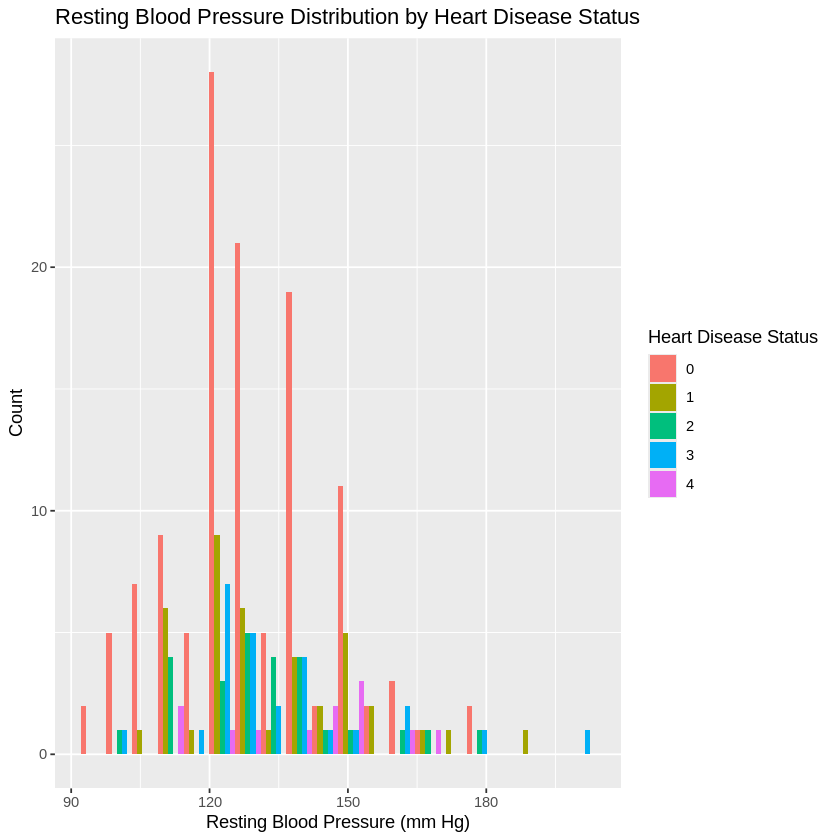

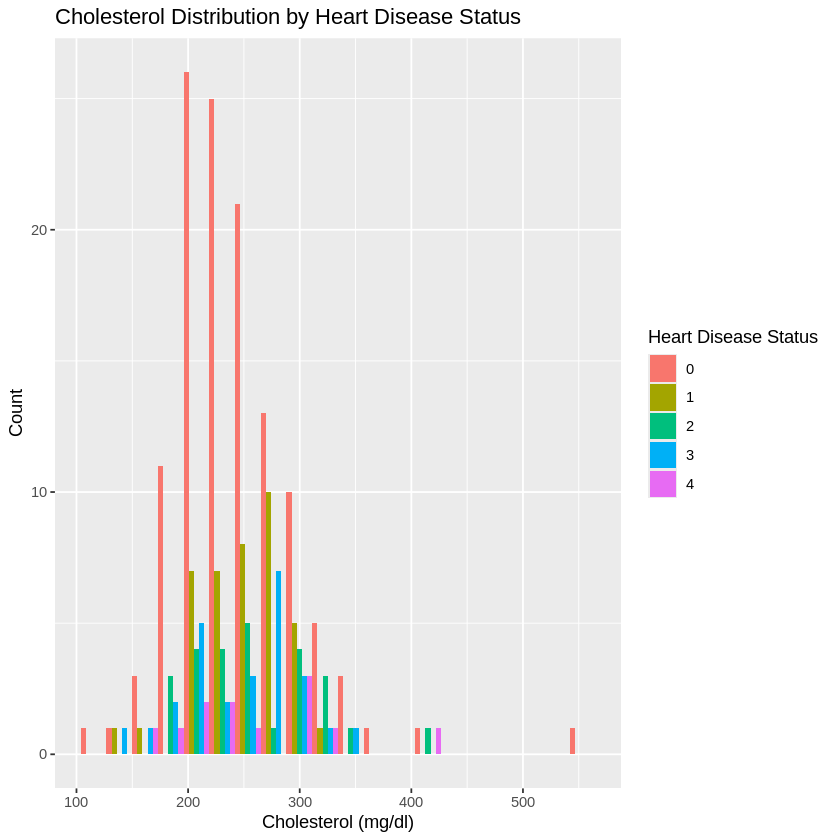

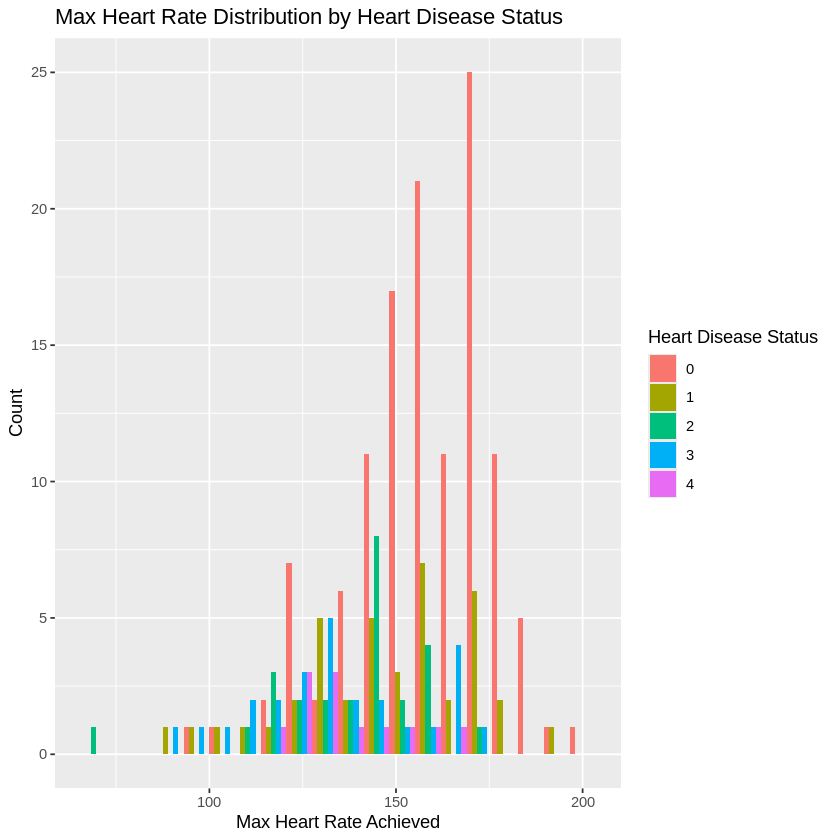

In [24]:
age_plot <- ggplot(cleveland_training, aes(x = age, fill = num)) +
             geom_histogram(bins = 20, position = "dodge") +
             labs(title = "Age Distribution by Heart Disease Status", 
                  x = "Age (Years)", 
                  y = "Count",
                  fill = "Heart Disease Status")

trestbps_plot <- ggplot(cleveland_training, aes(x = trestbps, fill = num)) +
             geom_histogram(bins = 20, position = "dodge") +
             labs(title = "Resting Blood Pressure Distribution by Heart Disease Status", 
                  x = "Resting Blood Pressure (mm Hg)",
                  y = "Count",  
                  fill = "Heart Disease Status")

chol_plot <- ggplot(cleveland_training, aes(x = chol, fill = num)) +
             geom_histogram(bins = 20, position = "dodge") +
             labs(title = "Cholesterol Distribution by Heart Disease Status", 
                  x = "Cholesterol (mg/dl)", 
                  y = "Count",
                  fill = "Heart Disease Status")

thalach_plot <- ggplot(cleveland_training, aes(x = thalach, fill = num)) +
             geom_histogram(bins = 20, position = "dodge") +
             labs(title = "Max Heart Rate Distribution by Heart Disease Status", 
                  x = "Max Heart Rate Achieved", 
                  y = "Count",
                  fill = "Heart Disease Status")

age_plot
trestbps_plot
chol_plot
thalach_plot

# Methods:

I will use logistic regression for classification (KNN - Kth nearest algorithm). The model will be trained using the training dataset and validated with a testing set. Key variables considered will include `age`, `trestbps`, `chol`, and `tha`.
First I will find the best value for K (nearest neighbor) in order to get the best results in terms of accuracy. After that, I will use the founded K value on classification model to check the accuracy and precision of the model on testing data set.

# Expected outcomes and significance:

### Expected Findings:
I expect to find that age, cholesterol levels, max heart rate, and blood pressure are significant predictors of heart disease and it will help to diagnose the heart disease. The logistic model should provide reasonable accuracy in predicting heart disease presence.

### Impact of Findings:
Such predictions can aid in early diagnosis and treatment, improving patient's health and reducing healthcare costs. The sooner the disease is found the sooner it can get treated.

### Future Questions:
Which machine learning models work best for detecting heart diseases? & what variables have the most impact on predicting heart disease cases?